# Interpolatiing Barium on a sphere

* A notebook of my work on interpolation from field obs. to grided data for the model run.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Content
1. [**Barium Samples**](#Barium-Samples)
  2. [GIPY 2007-11](#GIPY-2007-11)
  2. [BGEP 2003-2005](#BGEP-2003-2005)
  2. [CLIVAR Carbon and Hydrographic Data center](#CLIVAR-Carbon-and-Hydrographic-Data-center)
1. [**Interpolation**](#Interpolation)
  2. [Reconstruct vertical profiles](#Reconstruct-vertical-profiles)
  2. [Horizontal frame](#Horizontal-frame)
    3. [Projection transformation](#Projection-transformation)
    3. [Interpolating each layer](#Interpolating-each-layer)
1. [**Remap on ORCA2 frame**](#Remap-on-ORCA2-frame)
  2. [Plot](#Plot)

In [2]:
import sys
sys.path.insert(0, '_libs/')

In [3]:
import glob
#import pyproj
import scipy.io
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
% matplotlib inline

In [4]:
from NEMO_tools import int_profile, bin_profile, find_inland, reporj_NEMOgrid

In [5]:
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

In [6]:
def check_bounds(out, bounds_low, bounds_up):
    '''
    "What out of bounds becomes nan"
    '''
    out_adj = np.copy(out)
    for i in range(133):
        for j in range(17):
            if((out[i, j]<bounds_low[j]) | (out[i, j]>bounds_up[j])):
                out_adj[i, j]=np.nan
    return out_adj

In [7]:
def remove_nan(x, y, data):
    '''
    "Kriging does not like nan"
    '''
    data_temp = data[~np.isnan(data)]
    x_temp = x[~np.isnan(data)]
    y_temp = y[~np.isnan(data)]
    return x_temp, y_temp, data_temp

# Barium Samples

Only the sample labeled as **good** will be perserved ("moderate", "questionable", "unkonwn" etc. will not)

## GIPY 2007-11

* Data is collected from Jul 2007 to Sep 2007
* Only the "good" data points selected
* CTD depth above 15m as "surface"

In [8]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/GIPY11_Ba.mat')
GIPY_lons = MAT['Ba_records'][:, 0]
GIPY_lats = MAT['Ba_records'][:, 1]
GIPY_deps = MAT['Ba_records'][:, 2]
GIPY_Ba   = MAT['Ba_records'][:, 3]
#
GIPY_lons[GIPY_lons>180]=GIPY_lons[GIPY_lons>180]-360

## BGEP 2003-2005

* http://www.whoi.edu/page.do?pid=66521
* Data collected at the summer of 2003, 2004, 2005
* Only "Good" data points selected
* CTD depth above 15m as "surface"

In [9]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/BGEP_Ba.mat')
x03 = MAT['Ba2003'][:, 1]; y03 = MAT['Ba2003'][:, 0]; z03 = MAT['Ba2003'][:, 2]; Ba03 = MAT['Ba2003'][:, 3]
x04 = MAT['Ba2004'][:, 1]; y04 = MAT['Ba2004'][:, 0]; z04 = MAT['Ba2004'][:, 2]; Ba04 = MAT['Ba2004'][:, 3]
x04[Ba04<0]=np.nan; y04[Ba04<0]=np.nan; z04[Ba04<0]=np.nan; Ba04[Ba04<0]=np.nan
x05 = MAT['Ba2005'][:, 1]; y05 = MAT['Ba2005'][:, 0]; z05 = MAT['Ba2005'][:, 2]; Ba05 = MAT['Ba2005'][:, 3]

## CLIVAR Carbon and Hydrographic Data center

* [K. Falkner] HLY0301-32H120030721, http://seahunt.ucsd.edu/cruise/32H120030721
* [R. Woodgate] CBL-32PZ20020819, http://seahunt.ucsd.edu/cruise/32PZ20020819
* (X) [D. K. Fütterer] ARK-IX_4_1993-06AQ19930806, http://seahunt.ucsd.edu/cruise/06AQ19930806

In [10]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/HLY_Ba.mat')
xH = np.squeeze(MAT['lon'][:]); yH = np.squeeze(MAT['lat'][:]); zH = np.squeeze(MAT['dep'][:]); BaH = np.squeeze(MAT['Ba'][:])

In [11]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/CBL_Ba.mat')
xC = np.squeeze(MAT['lon'][:]); yC = np.squeeze(MAT['lat'][:]); zC = np.squeeze(MAT['dep'][:]); BaC = np.squeeze(MAT['Ba'][:])

## NCAR/EOL

https://www.aoncadis.org/search.html?page=1&freeText=Barium

* [K. Falkner] Hydrographic Parameters from Fram Strait and Denmark Strait, 1998 http://data.eol.ucar.edu/codiac/dss/id=106.ARCSS105
* [K. Falkner] Ba Con. and Salin. in Arctic River Estu., 1993-1996 https://www.aoncadis.org/dataset/ucar.ncar.eol.dataset.106_ARCSS107.html
* NPEO, North Pole Environmental Observatory 2000-2014

In [12]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/ARK14_Ba.mat')
xA14 = np.squeeze(MAT['lon'][:]); yA14 = np.squeeze(MAT['lat'][:]); zA14 = np.squeeze(MAT['dep'][:]); BaA14 = np.squeeze(MAT['Ba'][:])

In [13]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/NPEO_Ba.mat')
xNPEO = np.squeeze(MAT['lon'][:]); yNPEO = np.squeeze(MAT['lat'][:]); zNPEO = np.squeeze(MAT['dep'][:]); BaNPEO = np.squeeze(MAT['Ba'][:])

In [14]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/ARC_Ba.mat')
xARC = np.squeeze(MAT['lon'][:]); yARC = np.squeeze(MAT['lat'][:]); zARC = np.squeeze(MAT['dep'][:]); BaARC = np.squeeze(MAT['Ba'][:])

#Interpolation

## Reconstruct vertical profiles

In [15]:
#nc_name=glob.glob('_data/NEMO/ORCA2_LIM_PISCES/ORCA2_5d_19700101_19701231_ptrc_T*')
#nc_obj=nc.Dataset(nc_name[0])
#deptht = nc_obj.variables['deptht'][:]

In [16]:
deptht = np.array([5, 15, 25, 35, 45, 55, 75, 95, 115, 142, 182, 320, 511, 732, 1033, 1406, 1831, 2290, 2768, 3257, 3752, 4250, 4750, 5250]) 

In [17]:
BGEP_lons = np.hstack((x03, x04, x05))
BGEP_lats = np.hstack((y03, y04, y05))
BGEP_deps = np.hstack((z03, z04, z05))
BGEP_Ba   = np.hstack((Ba03, Ba04, Ba05))

In [18]:
x_all = np.hstack((GIPY_lons, x03, x04, x05, xH, xC, xA14, xNPEO, xARC))
y_all = np.hstack((GIPY_lats, y03, y04, y05, yH, yC, yA14, yNPEO, yARC))
z_all = np.hstack((GIPY_deps, z03, z04, z05, zH, zC, zA14, zNPEO, zARC))
Ba_all = np.hstack((GIPY_Ba, Ba03, Ba04, Ba05, BaH, BaC, BaA14, BaNPEO, BaARC))

In [19]:
tar_dep = 5250
dep_surf = deptht[deptht<tar_dep]

In [20]:
x_surf = x_all[z_all<tar_dep]; y_surf = y_all[z_all<tar_dep]; z_surf = z_all[z_all<tar_dep]; Ba_surf = Ba_all[z_all<tar_dep]

In [21]:
locx, locy, out_surf = int_profile(x_surf, y_surf, z_surf, Ba_surf, dep_surf, thres=2000)

In [24]:
x  = {'GIPY':GIPY_lons, 'BGEP':BGEP_lons, 'HLY':xH , 'CBL':xC , 'ARK14':xA14 , 'NPEO':xNPEO, 'ARC':xARC}
y  = {'GIPY':GIPY_lats, 'BGEP':BGEP_lats, 'HLY':yH , 'CBL':yC , 'ARK14':yA14 , 'NPEO':yNPEO, 'ARC':yARC}
z  = {'GIPY':GIPY_deps, 'BGEP':BGEP_deps, 'HLY':zH , 'CBL':zC , 'ARK14':zA14 , 'NPEO':zNPEO, 'ARC':zARC}
Ba = {'GIPY':GIPY_Ba  , 'BGEP':BGEP_Ba  , 'HLY':BaH, 'CBL':BaC, 'ARK14':BaA14, 'NPEO':BaNPEO, 'ARC':BaARC}
x_cut   = {'GIPY':[], 'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'ARC':[]}
y_cut   = {'GIPY':[], 'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'ARC':[]}
z_cut   = {'GIPY':[], 'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'ARC':[]}
Ba_cut  = {'GIPY':[], 'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'ARC':[]}
x_int   = {'GIPY':[], 'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'ARC':[]}
y_int   = {'GIPY':[], 'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'ARC':[]}
z_int   = {'GIPY':[], 'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'ARC':[]}
Ba_int  = {'GIPY':[], 'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'ARC':[]}
x_trans = {'GIPY':[], 'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'ARC':[]}
y_trans = {'GIPY':[], 'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'ARC':[]}
x_cord  = {'GIPY':[], 'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'ARC':[]}
y_cord  = {'GIPY':[], 'BGEP':[], 'HLY':[], 'CBL':[], 'ARK14':[], 'NPEO':[], 'ARC':[]}

keys = ['GIPY', 'BGEP', 'HLY', 'CBL', 'ARK14', 'NPEO', 'ARC']

In [25]:
for i in keys:
    x_cut[i] = x[i][z[i]<tar_dep]; y_cut[i] = y[i][z[i]<tar_dep]
    z_cut[i] = z[i][z[i]<tar_dep]; Ba_cut[i] = Ba[i][z[i]<tar_dep]
    x_int[i], y_int[i], Ba_int[i] = int_profile(x_cut[i], y_cut[i], z_cut[i], Ba_cut[i], dep_surf, thres=2000)

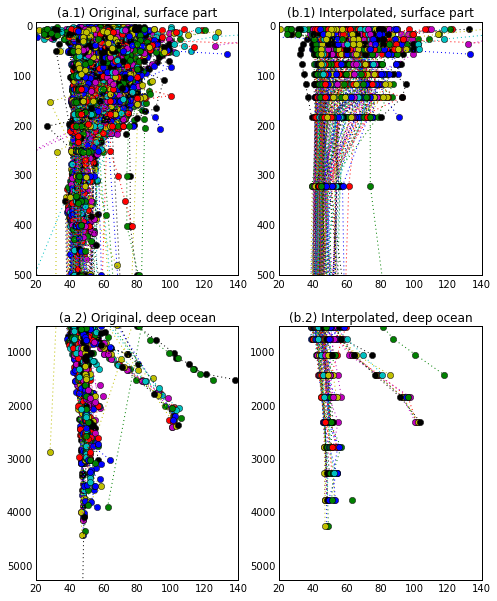

In [26]:
fig = plt.figure(figsize=(8, 10))
# Axis
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)
AX = [ax1, ax2, ax3, ax4]
for i in range(4):
    AX[i].set_xlim(20, 140)
    AX[i].xaxis.set_tick_params(size=0)
    AX[i].yaxis.set_tick_params(size=0)
# Fig1
ax1.set_ylim(-10, 500); ax1.invert_yaxis()
for i in range(len(locx)):
    ax1.plot(Ba_all[x_all==locx[i]], z_all[x_all==locx[i]], 'o:')
ax1.set_title('(a.1) Original, surface part', fontsize=12)
# Fig2
ax2.set_ylim(-10, 500); ax2.invert_yaxis()
ax2.plot(out_surf.T, dep_surf, 'o:')
ax2.set_title('(b.1) Interpolated, surface part')
# Fig3
ax3.set_ylim(500, tar_dep); ax3.invert_yaxis()
for i in range(len(locx)):
    ax3.plot(Ba_all[x_all==locx[i]], z_all[x_all==locx[i]], 'o:')
ax3.set_title('(a.2) Original, deep ocean', fontsize=12)
# Fig4
ax4.set_ylim(500, tar_dep); ax4.invert_yaxis()
ax4.plot(out_surf.T, dep_surf, 'o:')
ax4.set_title('(b.2) Interpolated, deep ocean')

## Horizontal frame

### Projection transformation

<img src="_figures/Projxy.PNG" width=450 align="left"/>

*The reference surface with geographic coordinates $\mathsf{(\phi,\lambda)}$ is projected onto a 2D Cartesian plane $\mathsf{(x, y)}$.*

In [30]:
p1=Basemap(projection='npstere', resolution='l', boundinglat=0, lon_0=90)
# create frame
listx_trans = np.linspace(0.95e7, 1.65e7, 100)
listy_trans = np.linspace(0.95e7, 1.65e7, 100)
gridx_trans, gridy_trans = np.meshgrid(listx_trans, listy_trans)
# convert frame back to lat/lon
listx, listy = p1(listx_trans, listy_trans, inverse=True)
gridx, gridy = p1(gridx_trans, gridy_trans, inverse=True)

In [31]:
# for CTD's locs
x_all_trans, y_all_trans = p1(locx, locy)
for i in keys:
    x_trans[i], y_trans[i] = p1(x_int[i], y_int[i])

### Interpolating each layer

data points participated: 324
data points participated: 410


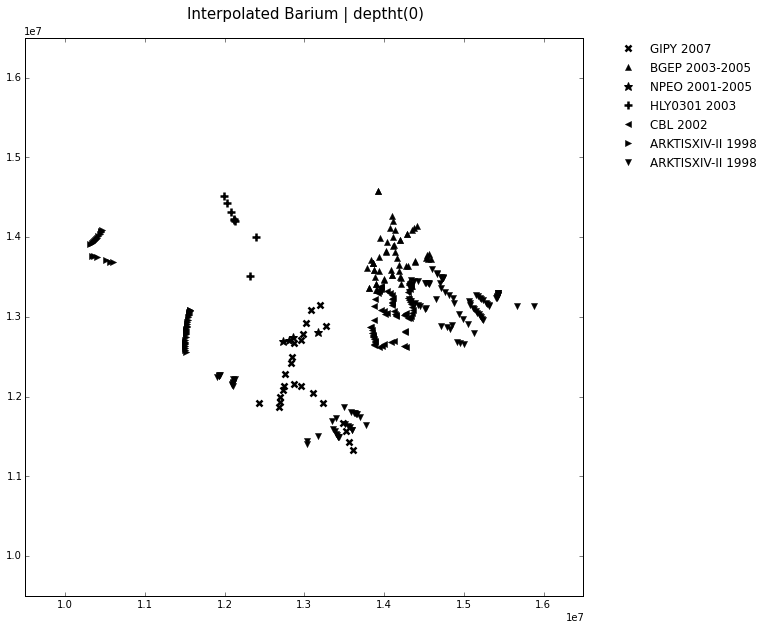

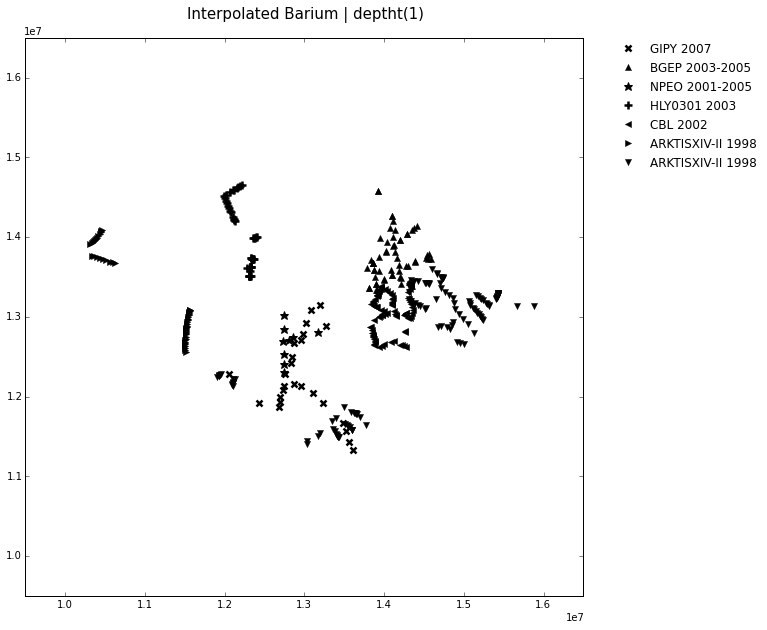

In [32]:
num_layer = 2
Ba_ini = np.empty([100, 100, num_layer])
for i in range(2):
    x_temp, y_temp, Ba_temp = remove_nan(x_all_trans, y_all_trans, out_surf[:, i])
    # plot cruises saperately
    for j in keys:
        x_cord[j], y_cord[j], _ = remove_nan(x_trans[j], y_trans[j], Ba_int[j][:, i])
        
    print('data points participated: {}'.format(len(Ba_temp)))# Check the the number of data
    # Kriging
    #OK = OrdinaryKriging(x_temp, y_temp, Ba_temp, variogram_model='linear', verbose=False, enable_plotting=False)
    #Ba_ini[:, :, i], ss = OK.execute('grid', listx_trans, listy_trans) # (gridx_trans, gridy_trans, Ba_int)
    # Plot
    fig=plt.figure(figsize=(10, 10))
    ax=fig.gca()
    ax.set_xlim(0.95e7, 1.65e7)
    ax.set_ylim(0.95e7, 1.65e7)
    #CS = ax.pcolor(gridx_trans, gridy_trans, Ba_int[:, :, i], vmin=30, vmax=100, cmap=plt.cm.gist_ncar_r)
    ax.plot(x_cord['GIPY'] , y_cord['GIPY'] , 'kx', ms=6, mew=2.5, label='GIPY 2007')
    ax.plot(x_cord['BGEP'] , y_cord['BGEP'] , 'k^', ms=6, mew=0.5, label='BGEP 2003-2005')
    ax.plot(x_cord['NPEO'] , y_cord['NPEO'] , 'k*', ms=9, mew=1.0, label='NPEO 2001-2005')
    ax.plot(x_cord['HLY']  , y_cord['HLY']  , 'k+', ms=8, mew=2.5, label='HLY0301 2003')
    ax.plot(x_cord['CBL']  , y_cord['CBL']  , 'k<', ms=6, mew=0.5, label='CBL 2002')
    ax.plot(x_cord['ARK14'], y_cord['ARK14'], 'k>', ms=6, mew=0.5, label='ARKTISXIV-II 1998')
    ax.plot(x_cord['ARC'], y_cord['ARC'], 'kv', ms=6, mew=0.5, label='ARCSS107-1993')
    #CBar = plt.colorbar(CS, shrink=0.575)
    #CBar.set_label('Interpolated diss.Ba con. ( 1E-6 mol/L )', fontsize=12)
    #CBar.ax.tick_params(axis='y', length=0)
    LG = ax.legend(numpoints=1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
    ax.set_title('Interpolated Barium | deptht('+str(i)+')', fontsize=15, y=1.025)    
    fig.savefig('Barium_layer_'+str(i)+'modified.pdf', dpi=400, orientation='portrait', papertype='a4', format='pdf',
            transparent=False, bbox_inches='tight', pad_inches=0)

# Remap on ORCA2 frame

In [33]:
coordinate_name=glob.glob('_data/NEMO/ORCA2_INPUT/coordinates*.nc')
#coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ORCA2_LIM_nemo_v3.4/coordinates*.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]

In [167]:
Ba_ini_orca = np.empty([149, 182, 2])
hit = find_inland(nav_lon, nav_lat)

In [ ]:
for i in range(num_layer):
    int_temp = reporj_NEMOgrid(gridx, gridy, Ba_ini[:, :, i], nav_lon, nav_lat, method='linear')
    int_temp[hit==1]=np.nan
    Ba_ini_orca[:, :, i] = int_temp

In [ ]:
Ba_ini_masked = np.ma.masked_where(np.isnan(Ba_ini_orca), Ba_ini_orca)

## Plot

In [34]:
ETOPO2_Arctic=scipy.io.loadmat('_libs/ETOPO2_Arctic.mat')
lon_arctic=ETOPO2_Arctic['lon_arctic']
lat_arctic=ETOPO2_Arctic['lat_arctic']
topo_arctic=ETOPO2_Arctic['topo_arctic']

In [35]:
# Adjust resolution
res_unit=5
lon_arctic=lon_arctic[0:-1:res_unit, 0:-1:res_unit]
lat_arctic=lat_arctic[0:-1:res_unit, 0:-1:res_unit]
topo_arctic=topo_arctic[0:-1:res_unit, 0:-1:res_unit]*-1

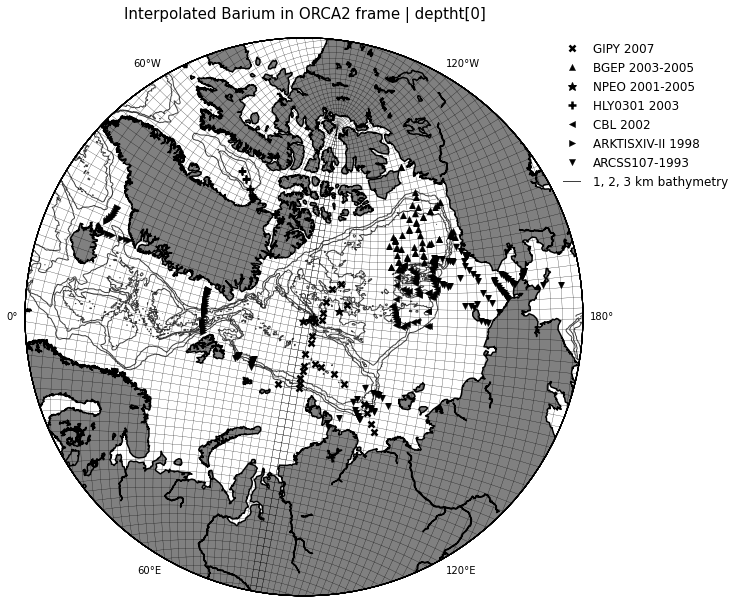

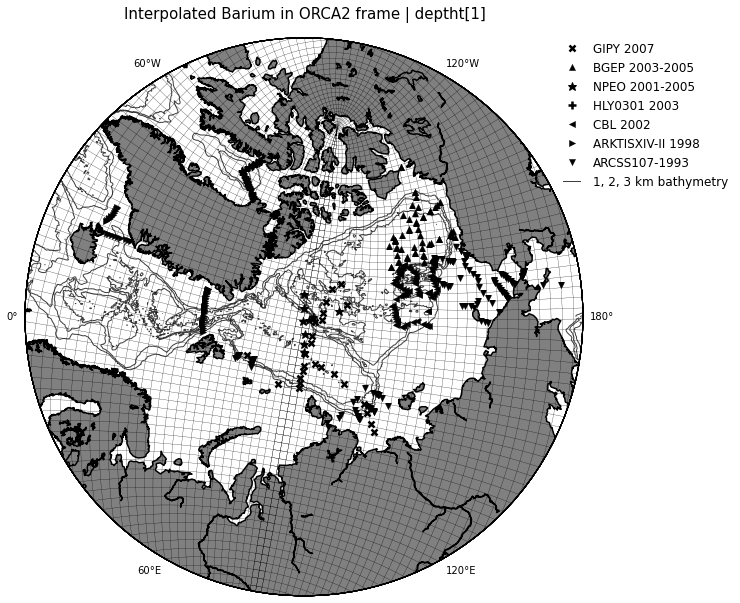

In [37]:
clevs=[1000, 2000, 3000]

for num in range(2):
    # Locations of CTDs
    for j in keys:
        x_cord[j], y_cord[j], _ = remove_nan(x_int[j], y_int[j], Ba_int[j][:, num])
    # Figures
    fig=plt.figure(figsize=(10, 10)); ax=plt.gca()
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=90, round=True, ax=ax)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
    proj.drawcoastlines(linewidth=1.5, color='k')
    gridx, gridy = proj(nav_lon, nav_lat)
    topox, topoy = proj(lon_arctic, lat_arctic)
    for j in keys:
        x_cord[j], y_cord[j] = proj(x_cord[j], y_cord[j])
    #CS = proj.pcolor(gridx, gridy, Ba_ini_masked[:, :, num], vmin=30, vmax=100, cmap=plt.cm.gist_ncar_r)
    CS2 = proj.contour(topox, topoy, topo_arctic, clevs, linestyles='-', linewidths=1, colors=('k',), alpha=0.75)
    CS2.collections[0].set_label('1, 2, 3 km bathymetry')
    proj.plot(x_cord['GIPY'] , y_cord['GIPY'] , 'kx', ms=6, mew=2.5, label='GIPY 2007')
    proj.plot(x_cord['BGEP'] , y_cord['BGEP'] , 'k^', ms=6, mew=0.5, label='BGEP 2003-2005')
    proj.plot(x_cord['NPEO'] , y_cord['NPEO'] , 'k*', ms=9, mew=1.0, label='NPEO 2001-2005')
    proj.plot(x_cord['HLY']  , y_cord['HLY']  , 'k+', ms=8, mew=2.5, label='HLY0301 2003')
    proj.plot(x_cord['CBL']  , y_cord['CBL']  , 'k<', ms=6, mew=0.5, label='CBL 2002')
    proj.plot(x_cord['ARK14'], y_cord['ARK14'], 'k>', ms=6, mew=0.5, label='ARKTISXIV-II 1998')
    proj.plot(x_cord['ARC'], y_cord['ARC'], 'kv', ms=6, mew=0.5, label='ARCSS107-1993')
    proj.plot(gridx.T, gridy.T, 'k-', lw=0.25)
    proj.plot(gridx, gridy, 'k-', lw=0.25)
    #cbaxes = fig.add_axes([0.975, 0.15, 0.02, 0.5]) 
    #CBar = plt.colorbar(CS, ax=ax, cax=cbaxes) 
    #CBar.set_label('Interpolated diss.Ba con. ( 1E-6 mol/L )', fontsize=12)
    #CBar.ax.tick_params(axis='y', length=0)
    LG = ax.legend(numpoints=1, bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
    ax.set_title('Interpolated Barium in ORCA2 frame | deptht['+str(num)+']', fontsize=15, y=1.025)
    #fig.savefig('Publish/Barium_4.pdf', dpi=600, orientation='portrait', papertype='a4', format='pdf',
    #            transparent=False, bbox_inches='tight', pad_inches=0)

In [31]:
# Save
save_var = { 'Ba_ini_orca': Ba_ini_orca, 'nav_lon': nav_lon, 'nav_lat': nav_lat}
scipy.io.savemat('Temp_Ba_int.mat', mdict=save_var)